In [107]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm

In [108]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [109]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [110]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


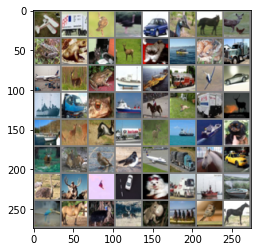

plane truck bird  bird  car   bird  horse deer  frog  frog  cat   deer  dog   ship  deer  truck plane deer  frog  ship  ship  truck plane car   ship  truck frog  ship  horse dog   truck deer  ship  deer  bird  truck deer  ship  ship  dog   deer  deer  bird  bird  plane truck horse car   bird  deer  plane car   dog   truck ship  ship  bird  horse bird  deer  frog  ship  bird  horse


In [111]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [112]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [113]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.01,momentum = 0):
    history = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
    return history, end

In [114]:
begin = time.time()
history, end = fit(30, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|██████████| 657/657 [00:10<00:00, 62.94it/s]


Epoch [0], Time taken :12.7239, train_loss : 2.3029, train_acc: 0.1080, val_loss: 2.3005, val_acc: 0.1198


100%|██████████| 657/657 [00:10<00:00, 64.58it/s]


Epoch [1], Time taken :11.9522, train_loss : 2.2970, train_acc: 0.1360, val_loss: 2.2901, val_acc: 0.1494


100%|██████████| 657/657 [00:10<00:00, 65.08it/s]


Epoch [2], Time taken :11.8734, train_loss : 2.2428, train_acc: 0.1708, val_loss: 2.1715, val_acc: 0.1957


100%|██████████| 657/657 [00:10<00:00, 60.79it/s]


Epoch [3], Time taken :12.5910, train_loss : 2.1121, train_acc: 0.2221, val_loss: 2.0366, val_acc: 0.2495


100%|██████████| 657/657 [00:10<00:00, 64.65it/s]


Epoch [4], Time taken :11.9562, train_loss : 1.9835, train_acc: 0.2711, val_loss: 1.9110, val_acc: 0.2889


100%|██████████| 657/657 [00:10<00:00, 65.23it/s]


Epoch [5], Time taken :11.8366, train_loss : 1.8784, train_acc: 0.3067, val_loss: 1.8302, val_acc: 0.3307


100%|██████████| 657/657 [00:10<00:00, 61.95it/s]


Epoch [6], Time taken :12.4398, train_loss : 1.7830, train_acc: 0.3443, val_loss: 1.7520, val_acc: 0.3561


100%|██████████| 657/657 [00:10<00:00, 65.21it/s]


Epoch [7], Time taken :11.8429, train_loss : 1.7081, train_acc: 0.3690, val_loss: 1.6728, val_acc: 0.3812


100%|██████████| 657/657 [00:09<00:00, 66.36it/s]


Epoch [8], Time taken :11.7979, train_loss : 1.6488, train_acc: 0.3936, val_loss: 1.8749, val_acc: 0.3548


100%|██████████| 657/657 [00:10<00:00, 63.02it/s]


Epoch [9], Time taken :12.5109, train_loss : 1.6035, train_acc: 0.4109, val_loss: 1.5736, val_acc: 0.4206


100%|██████████| 657/657 [00:09<00:00, 66.14it/s]


Epoch [10], Time taken :11.7697, train_loss : 1.5593, train_acc: 0.4270, val_loss: 1.5617, val_acc: 0.4261


100%|██████████| 657/657 [00:10<00:00, 65.14it/s]


Epoch [11], Time taken :12.3614, train_loss : 1.5251, train_acc: 0.4421, val_loss: 1.5559, val_acc: 0.4329


100%|██████████| 657/657 [00:09<00:00, 66.25it/s]


Epoch [12], Time taken :11.6665, train_loss : 1.4860, train_acc: 0.4576, val_loss: 1.5154, val_acc: 0.4588


100%|██████████| 657/657 [00:09<00:00, 66.81it/s]


Epoch [13], Time taken :11.5599, train_loss : 1.4507, train_acc: 0.4727, val_loss: 1.4487, val_acc: 0.4791


100%|██████████| 657/657 [00:10<00:00, 62.87it/s]


Epoch [14], Time taken :12.2474, train_loss : 1.4219, train_acc: 0.4831, val_loss: 1.4398, val_acc: 0.4816


100%|██████████| 657/657 [00:09<00:00, 66.16it/s]


Epoch [15], Time taken :11.6763, train_loss : 1.3911, train_acc: 0.4965, val_loss: 1.4038, val_acc: 0.4920


100%|██████████| 657/657 [00:09<00:00, 65.78it/s]


Epoch [16], Time taken :11.7765, train_loss : 1.3616, train_acc: 0.5084, val_loss: 1.5678, val_acc: 0.4672


100%|██████████| 657/657 [00:10<00:00, 62.40it/s]


Epoch [17], Time taken :12.2776, train_loss : 1.3359, train_acc: 0.5159, val_loss: 1.3632, val_acc: 0.5111


100%|██████████| 657/657 [00:10<00:00, 65.24it/s]


Epoch [18], Time taken :11.8494, train_loss : 1.3015, train_acc: 0.5345, val_loss: 1.3177, val_acc: 0.5285


100%|██████████| 657/657 [00:09<00:00, 66.48it/s]


Epoch [19], Time taken :11.6817, train_loss : 1.2761, train_acc: 0.5420, val_loss: 1.2876, val_acc: 0.5384


100%|██████████| 657/657 [00:10<00:00, 62.32it/s]


Epoch [20], Time taken :12.6161, train_loss : 1.2507, train_acc: 0.5542, val_loss: 1.3035, val_acc: 0.5406


100%|██████████| 657/657 [00:09<00:00, 67.28it/s]


Epoch [21], Time taken :11.6658, train_loss : 1.2238, train_acc: 0.5655, val_loss: 1.2604, val_acc: 0.5554


100%|██████████| 657/657 [00:09<00:00, 67.70it/s]


Epoch [22], Time taken :12.0715, train_loss : 1.1999, train_acc: 0.5732, val_loss: 1.2486, val_acc: 0.5566


100%|██████████| 657/657 [00:09<00:00, 66.07it/s]


Epoch [23], Time taken :11.6804, train_loss : 1.1774, train_acc: 0.5832, val_loss: 1.2373, val_acc: 0.5711


100%|██████████| 657/657 [00:09<00:00, 66.26it/s]


Epoch [24], Time taken :11.6375, train_loss : 1.1503, train_acc: 0.5922, val_loss: 1.2603, val_acc: 0.5556


100%|██████████| 657/657 [00:10<00:00, 62.40it/s]


Epoch [25], Time taken :12.3065, train_loss : 1.1295, train_acc: 0.6052, val_loss: 1.1952, val_acc: 0.5879


100%|██████████| 657/657 [00:09<00:00, 65.93it/s]


Epoch [26], Time taken :11.6950, train_loss : 1.1043, train_acc: 0.6125, val_loss: 1.2912, val_acc: 0.5594


100%|██████████| 657/657 [00:09<00:00, 67.23it/s]


Epoch [27], Time taken :11.5103, train_loss : 1.0801, train_acc: 0.6230, val_loss: 1.1294, val_acc: 0.6116


100%|██████████| 657/657 [00:10<00:00, 63.05it/s]


Epoch [28], Time taken :12.1668, train_loss : 1.0571, train_acc: 0.6298, val_loss: 1.3720, val_acc: 0.5365


100%|██████████| 657/657 [00:09<00:00, 67.08it/s]


Epoch [29], Time taken :11.5371, train_loss : 1.0382, train_acc: 0.6385, val_loss: 1.1967, val_acc: 0.5844
Finished Training in 359.66032886505127secs


In [115]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

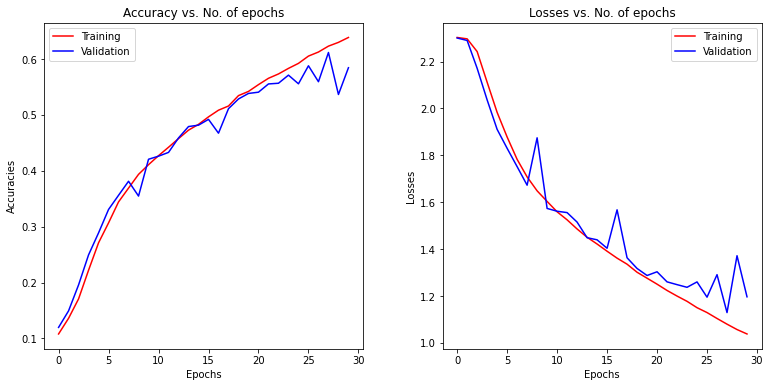

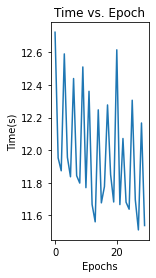

In [116]:
def plot_results(history):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(131)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(132)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(1,3,3)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
              
plot_results(history)

In [117]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [118]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 58 %


In [119]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.5 %
Accuracy for class: car   is 70.0 %
Accuracy for class: bird  is 35.4 %
Accuracy for class: cat   is 21.5 %
Accuracy for class: deer  is 66.9 %
Accuracy for class: dog   is 35.9 %
Accuracy for class: frog  is 63.8 %
Accuracy for class: horse is 82.7 %
Accuracy for class: ship  is 73.5 %
Accuracy for class: truck is 64.3 %
